# Walmart Sales Forecasting

<ul>
    <li> Start time and date: December 17, 12:39 PM EST </li>
    <li> End time and date: December 18, 2:47 PM EST </li>
</ul>

Given data about weekly sales at Walmart stores across the US we are asked to predict weekly sales given department, store and a specific week during the year. In essence, we want to build a regression model to predict sales minimizing MSE or MAE.



## Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
sales_df = pd.read_csv('train.csv')

In [3]:
features_df.sample(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
2790,16,2011-04-01,35.75,3.461,NaN,NaN,NaN,NaN,NaN,192.269171,6.339,False
5643,32,2010-02-12,28.09,2.572,NaN,NaN,NaN,NaN,NaN,189.464273,9.014,True
806,5,2011-08-05,91.07,3.684,NaN,NaN,NaN,NaN,NaN,216.107120,6.529,False
1456,9,2010-02-05,38.01,2.572,NaN,NaN,NaN,NaN,NaN,214.655459,6.415,False
1294,8,2010-06-25,81.78,2.653,NaN,NaN,NaN,NaN,NaN,214.712629,6.290,False
4983,28,2011-06-03,71.81,4.031,NaN,NaN,NaN,NaN,NaN,129.049032,13.736,False
5890,33,2011-05-13,78.24,4.202,NaN,NaN,NaN,NaN,NaN,129.089000,8.687,False
6868,38,2012-08-31,89.78,4.093,489.03,NaN,28.64,334.12,1760.26,130.885355,10.926,False
2825,16,2011-12-02,27.83,3.378,516.47,61.0,944.52,9.00,7124.75,195.822329,6.232,False
2015,12,2010-05-07,70.15,3.127,NaN,NaN,NaN,NaN,NaN,126.289800,14.099,False


In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


Most of the missing values come from the `Markdown` columns. We will have to impute these values if necessary.

In [5]:
sales_df.sample(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
124518,13,55,2011-05-06,12351.10,False
54045,6,38,2012-09-28,71173.04,False
27927,3,79,2011-11-04,6844.26,False
406850,44,16,2011-11-25,681.44,True
12521,2,17,2012-08-17,14577.63,False
275185,28,81,2012-09-07,27370.05,True
163626,17,51,2011-07-22,3.96,False
338849,35,83,2011-06-17,557.18,False
130723,14,20,2011-10-28,8430.03,False
230638,24,28,2011-05-20,703.20,False


In [6]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


No missing values for any of the columns in our sales_df. Let's merge these two datasets perforiming a left join on `sales_df`.

In [7]:
df = pd.merge(sales_df, features_df, on = ['Date', 'Store'], how = 'left')
df.shape

(421570, 15)

In [8]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Let's drop `IsHoliday_y` since it is redundant.

In [9]:
(df['IsHoliday_y'] == df['IsHoliday_x']).value_counts()

True    421570
dtype: int64

In [10]:
df = df.drop(['IsHoliday_y'], axis = 1)
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')

In [11]:
df.columns = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment']

In [12]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


Let's look at the `store_df` dataframe.

In [13]:
stores_df.sample(5)

,Store,Type,Size
1,2,A,202307
12,13,A,219622
41,42,C,39690
32,33,A,39690
37,38,C,39690


In [14]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [15]:
stores_df['Type'].describe()

count     45
unique     3
top        A
freq      22
Name: Type, dtype: object

In [16]:
stores_df['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [17]:
s1 = stores_df[stores_df['Type']=='A']['Size'].rename('Size(A)').describe()
s2 = stores_df[stores_df['Type']=='B']['Size'].rename('Size(B)').describe()
s3 = stores_df[stores_df['Type']=='C']['Size'].rename('Size(C)').describe()

In [18]:
pd.DataFrame([s1,s2,s3])

,count,mean,std,min,25%,50%,75%,max
Size(A),22.0,177247.727273,49392.621098,39690.0,155840.75,202406.0,203819.0,219622.0
Size(B),17.0,101190.705882,32371.137916,34875.0,93188.00,114533.0,123737.0,140167.0
Size(C),6.0,40541.666667,1304.145033,39690.0,39745.00,39910.0,40774.0,42988.0


On average, companies of type A and B are considerably bigger in size than type C. Let's perform a left join with dataframe `stores_df` on the columns `Store`.

In [19]:
df = pd.merge(df, stores_df, on = 'Store', how = 'left')

In [20]:
df.shape

(421570, 16)

In [21]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


Before we start exploring the data we would like to convert the date entries into datetime objects. `pandas` has a builtin method that can do this for us.

In [22]:
df['Date'] = pd.to_datetime(df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

Now it is of the datatype we want.

In [23]:
df['Date'].describe()

count                  421570
unique                    143
top       2011-12-23 00:00:00
freq                     3027
first     2010-02-05 00:00:00
last      2012-10-26 00:00:00
Name: Date, dtype: object

In [24]:
features_df['Date'].describe()

count                    8190
unique                    182
top       2011-07-15 00:00:00
freq                       45
first     2010-02-05 00:00:00
last      2013-07-26 00:00:00
Name: Date, dtype: object

Now we have all our features organized in one dataframe. We will go ahead and start the EDA phase.

## Data Exploration

We first look at distribution of sales for certain predictors. But first, let's look at the overall distribution.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

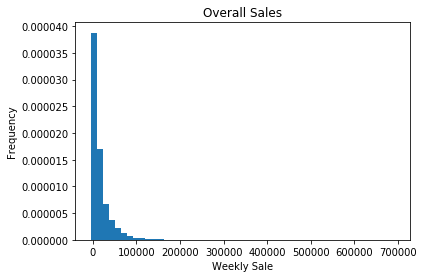

In [26]:
plt.hist(df['Weekly_Sales'], density = True, bins = 50)
plt.xlabel('Weekly Sale')
plt.ylabel('Frequency')
plt.title('Overall Sales')

plt.show()

Although we might not be able to see some values near 700000, there are sales that occured near that mark. To illustrate that point we can compute the max weekly sales as shown below.

In [27]:
max(df['Weekly_Sales'])

693099.36

Notice we also have negative sales. When we fit our model we will experiment whether to include negative sales or not.

In [28]:
df[df['Weekly_Sales']<0].shape

(1285, 16)

### Holiday vs. Non-Holiday

Now let's see if there is any change in distribution between holidays versus non-holiday weekly sales.

In [29]:
df_holiday = df[df['IsHoliday'] == True]
df_non_holiday = df[df['IsHoliday'] == False]

In [30]:
def plot_hist(int_min = 0, int_max = 100000):
    df1 = df_holiday
    df2 = df_non_holiday
    
    plt.hist(df1['Weekly_Sales'][(df1['Weekly_Sales'] > int_min) & (df1['Weekly_Sales'] <int_max)], 
             bins = 50, alpha = 0.5, label = 'Holiday')
    plt.hist(df2['Weekly_Sales'][(df2['Weekly_Sales'] > int_min) & (df2['Weekly_Sales'] <int_max)],
             bins = 50, alpha = 0.5, label = 'non-Holiday')
    plt.xlabel('Weekly Sale')
    plt.ylabel('Frequency')
    plt.title('Weekly Sales in the range [{},{}]'.format(int_min, int_max))
    plt.legend(loc = "upper right")

    plt.show()
    

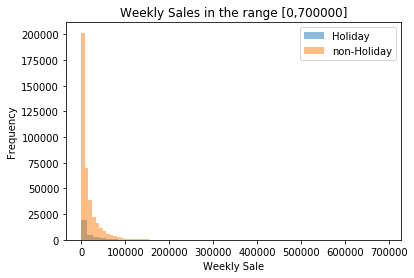

In [31]:
plot_hist(0,700000)

It's quite hard to see the difference here because of the heavy right skew of the distribution. We can fix this by plotting two histograms based on a cutoff at 100000.

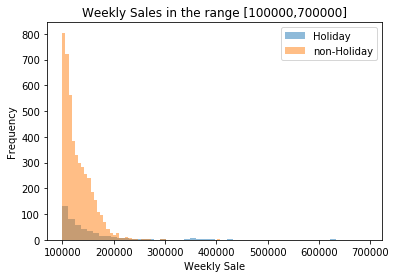

In [32]:
plot_hist(100000,700000)

Weekly sales below 200000 are quite common for both non-Holiday and Holiday weeks. Let's look at sales 200000 and greater.

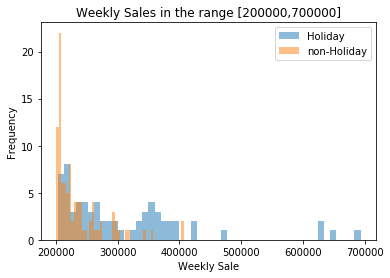

In [33]:
plot_hist(200000, 700000)

We can clearly see that high weekly sales (i.e. 300000 or more) occur during Holiday weeks. 

### Sales by Store

We want to see if any store feature has a correlation with weekly sales. Starting with store number (which intuitively won't have any relationship with high or low weekly sales but we will plot a bar graph to illustrate this point; that is, store is a categorical variable). Then, we will group by variables `type` and `size` to see how the average weekly sales amount changes.

In [36]:
def plot_by_store(col = 'Store'):
    
    my_df = pd.DataFrame()
    my_df = df.groupby(col).mean().reset_index()    
    
    plt.bar(my_df[col], my_df['Weekly_Sales'])
    plt.xlabel(col)
    plt.ylabel('Average Weekly Sales')

    plt.show()

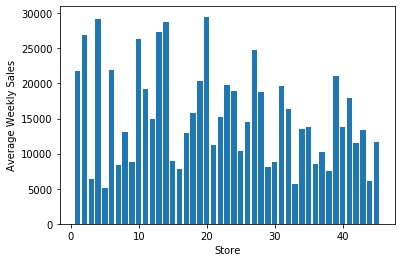

In [37]:
plot_by_store()

There is no clear correlation between average weekly sales and store number. Instead, we can take store size and type to see if there is any.

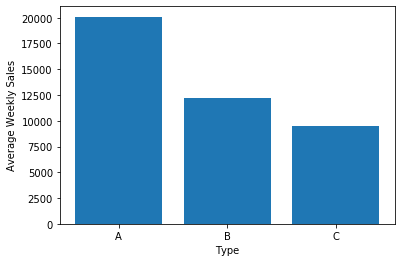

In [38]:
plot_by_store('Type')

As we saw earlier a dtermining factor of store type is size with type `A` having the highest average store size and `C` having the lowest. We confirm this by graphing a scatter plot of mean weekly sales by store size.

In [39]:
my_df = df.groupby('Size').mean().reset_index()  

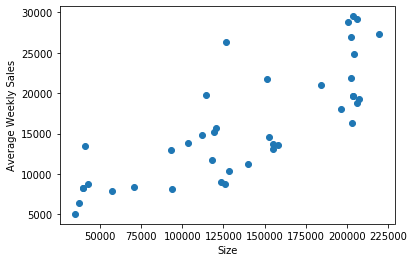

In [40]:
plt.scatter(my_df['Size'], my_df['Weekly_Sales'])
plt.xlabel('Size')
plt.ylabel('Average Weekly Sales')

plt.show()

The two plots above show that `Type` and `Size` encapsulate the influence of store number in our models. So we may safely drop the field `Store`.

### Helper Functions

In [41]:
def plot_by(col = 'Date', rotation = 70):
    
    my_df = pd.DataFrame()
    my_df = df.groupby(col).mean().reset_index()    
    
    plt.scatter(my_df[col], my_df['Weekly_Sales'])
    plt.xlabel(col)
    plt.ylabel('Average Weekly Sales')

    plt.xticks(rotation=rotation)
    
    plt.show()

In [42]:
def plot_store(store = 1, x = 'Date', rotation = 70):
    
      
    my_df = df[df['Store'] == store].groupby(x).mean().reset_index()    

    
    plt.scatter(my_df[x], my_df['Weekly_Sales'])
    
    plt.xlabel(x)
    plt.ylabel('Average Weekly Sales')
    plt.xticks(rotation = rotation)
    plt.title('Store {}'.format(store))
    
    plt.show()

### Sales by Date

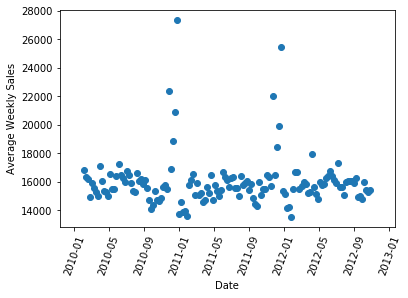

In [43]:
plot_by()

Let's check which dates correspond to these huge mean weekly sales that are above 18000.

In [44]:
my_df = df.groupby('Date').mean().reset_index()    

my_df[my_df['Weekly_Sales']>18000]['Date']

42   2010-11-26
44   2010-12-10
45   2010-12-17
46   2010-12-24
94   2011-11-25
96   2011-12-09
97   2011-12-16
98   2011-12-23
Name: Date, dtype: datetime64[ns]

We notice dates that correspond to Black friday in November and the rest of the dates happen to be before Christmas. So it would be safe to say year-end holidays drive a huge amount of sales at Walmart.

In [45]:
my_df[my_df['Weekly_Sales']>24000]['Date']

46   2010-12-24
98   2011-12-23
Name: Date, dtype: datetime64[ns]

Can we find nonzero markdown fields during these dates?

In [48]:
import datetime

def convert_datetime(date_time_str):
    '''
        argument format should be %d/%m/%Y (i.e. '10/11/2011')
    '''
    return datetime.datetime.strptime(date_time_str, '%d/%m/%Y')


In [49]:
convert_datetime('10/11/2011')


datetime.datetime(2011, 11, 10, 0, 0)

In [51]:
holidays_2011 = (features_df['Date'] > convert_datetime('17/11/2011')) & (features_df['Date'] < convert_datetime('31/12/2011'))

features_df[holidays_2011]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
93,1,2011-11-18,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False
94,1,2011-11-25,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,True
95,1,2011-12-02,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False
96,1,2011-12-09,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False
97,1,2011-12-16,51.63,3.159,5011.32,67.00,347.37,225.79,4011.37,219.179453,7.866,False
98,1,2011-12-23,47.96,3.112,2725.36,40.48,634.70,24.90,2739.43,219.357722,7.866,False
99,1,2011-12-30,44.55,3.129,5762.10,46011.38,260.36,983.65,4735.78,219.535990,7.866,True
275,2,2011-11-18,62.01,3.308,6490.92,1217.76,152.12,873.82,7656.42,217.867022,7.441,False
276,2,2011-11-25,56.36,3.236,919.71,62.00,77451.26,23.00,1589.43,218.113027,7.441,True
277,2,2011-12-02,48.74,3.172,8010.99,83.47,1897.27,4444.00,28238.93,218.359032,7.441,False


Yes! The end of year holidays in 2011 have nonzero markdown weeks!

### Sales by Temperature and Fuel Price

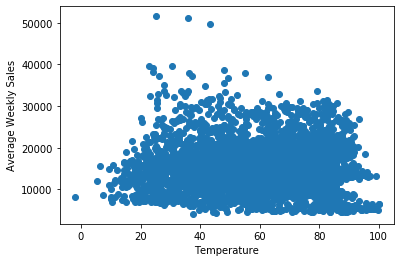

In [52]:
plot_by('Temperature',0)

The highest average sales correspond to temperatures in the range [20,55] degrees Fahrenheit, which happens to be where most average temperatures in the US lie during the months of November and December. So, in a sense, temperature is already encoded in the column `Date`. We will decide to include temperature depending on whether it improves the accuracy of our predictive models.

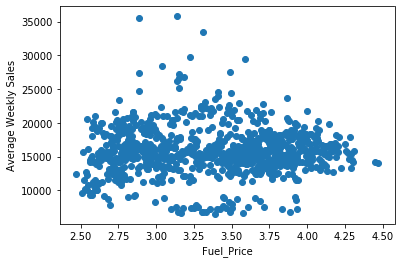

In [53]:
plot_by('Fuel_Price', 0)

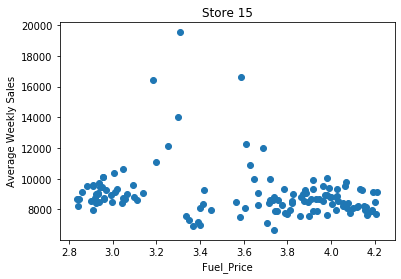

In [54]:
plot_store(15, 'Fuel_Price', 0)

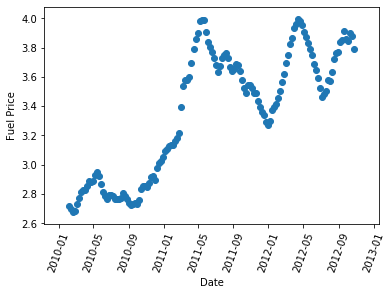

In [55]:
fuel_by_week = df.groupby('Date').mean().reset_index()

plt.scatter(fuel_by_week['Date'],fuel_by_week['Fuel_Price'])
plt.xlabel('Date')
plt.ylabel('Fuel Price')
plt.xticks(rotation = 70)

plt.show()



Similar to temperature, fuel price is an indicator of time of the year. There is a seasonal trend in fuel price. So it will be safe to drop this column as well. The plot above shows us exactly this point. During the summer months gas is more expensive.

### Sales by Markdown

There are five fields corresponding to markdowns in the `features` data set. We are interested in the total sum. Let's create a new field and name it `MarkDownTotal`.

In [56]:
df.fillna(0, inplace=True)

In [57]:
markdown_list = [df[name] for name in ['MarkDown' + str(i) for i in range(1,6)]]

df['MarkDownTotal'] = sum(markdown_list)

In [58]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,MarkDownTotal
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0.0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,0.0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0.0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0.0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0.0


There is no clear relationship between increasing Markdown and weekly sales. To the contrary, weekly sales hit their maximum in the absence of a markdown as we can see below.

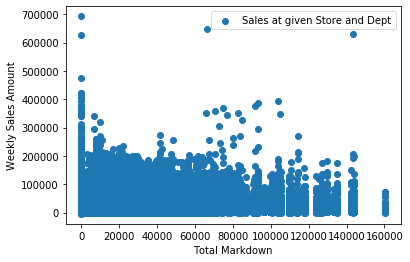

In [59]:
plt.scatter(df['MarkDownTotal'],df['Weekly_Sales'], label = 'Sales at given Store and Dept')
plt.xlabel('Total Markdown')
plt.ylabel('Weekly Sales Amount')
plt.legend(loc = "upper right")

plt.show()

There is no correlation between markdown and weekly sales at a given store and department. Usually, promotions and discounts are meant for items in surplus which, in most cases, is out of fashion or out of date.

First, let's confirm our assumptions. Markdowns happen during holidays.

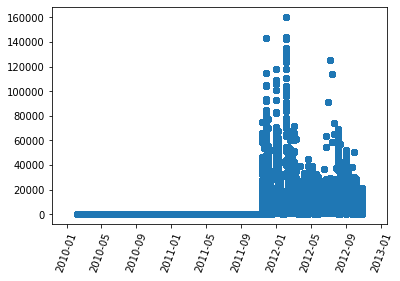

In [60]:
plt.scatter(df['Date'],df['MarkDownTotal'])
plt.xticks(rotation = 70)
plt.show()

There are no markdowns before November of 2011. Let's restrict our domain to dates after.

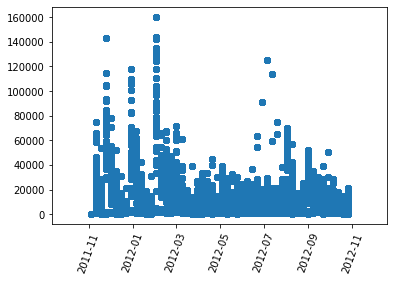

In [61]:
dates_after_nov = df['Date'] > convert_datetime('1/11/2011')

plt.scatter(df[dates_after_nov]['Date'],df[dates_after_nov]['MarkDownTotal'])
plt.xticks(rotation = 70)
plt.show()

Here we can see markdowns coincide with holiday seasons; but they also appear at the beginning of Spring and Summer. It's safe to keep this field, along with the individual breakdowns.

### Sales by Department

A quick scatter plot for weekly sales at a given store and department by department.

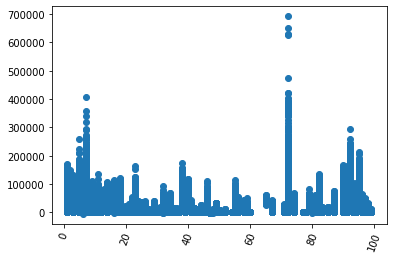

In [62]:
plt.scatter(df['Dept'],df['Weekly_Sales'])
plt.xticks(rotation = 70)
plt.show()

There are two departments that stand out. Let's average weekly sales by department and see which departments are popular in terms of sales.

In [64]:
def plot_by_dept(dept = 1, rotation = 70):
    
    
    col = 'Date'
      
    my_df = df[df['Dept'] == dept].groupby(col).mean().reset_index()    

    
    plt.scatter(my_df['Date'], my_df['Weekly_Sales'])
    
    plt.xlabel(col)
    plt.ylabel('Average Weekly Sales')
    plt.xticks(rotation=rotation)
    
    plt.title('Department {}'.format(dept))
    
    plt.show()

In [65]:
df['Dept'].describe()

count    421570.000000
mean         44.260317
std          30.492054
min           1.000000
25%          18.000000
50%          37.000000
75%          74.000000
max          99.000000
Name: Dept, dtype: float64

There are 99 departments. One thing to note is that not all departments are present accross all fifty stores. Some walmart stores are bigger than others. Using the helper function above we can see that there are some departments that have seasonal trends. For instance, let's take a look at department 16.

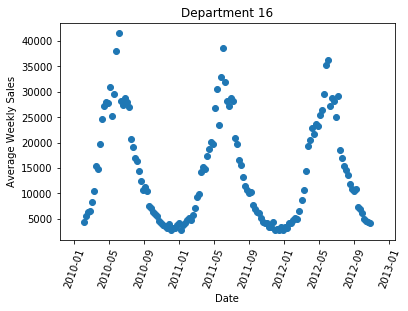

In [66]:
plot_by_dept(16)

However, there are departments are not influenced by season or time.

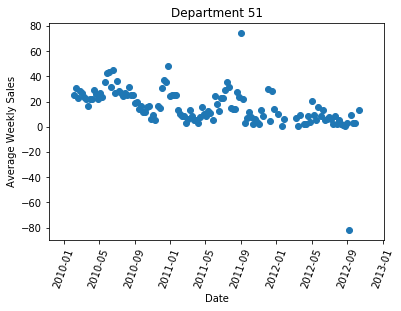

In [67]:
plot_by_dept(51)

It is safe to say that deparment, in and of itself, is an important feature that predicts weekly sales.

### Sales by Unemployment and CPI

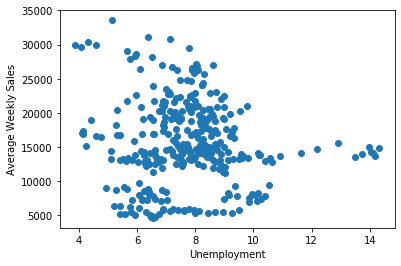

In [68]:
plot_by('Unemployment', 0)

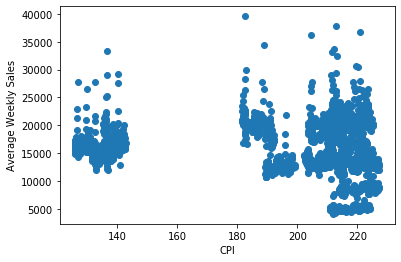

In [69]:
plot_by('CPI', 0)

There isn't much we can gloss over from the scatter plot above. We need to see how unemployment and CPI affect weekly sales for a particular store. So first we restrict to a given store and then plot unemployment/CPI against weekly sales. Let's go!

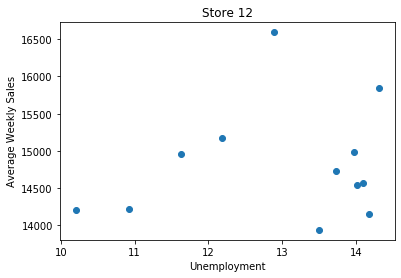

In [70]:
plot_store(12, 'Unemployment', 0)

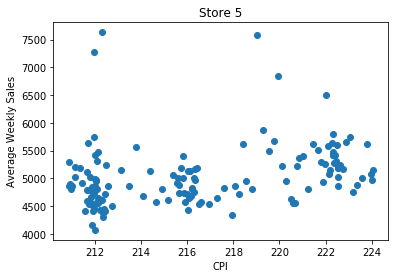

In [71]:
plot_store(5, 'CPI', 0)

There is no clear correlation between average weekly sales and unemployment given a specific store. The same is true for consumer price indices. It will be safe to drop these two columns from our final list of features.

## Feature Engineering

We first work with the `date` columns. In order to capture trends, whether seasonal or yearly, we need to break the data into separate components as below.

In [72]:
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Week'] = df['Date'].apply(lambda x: x.week)
df['Season'] = df['Date'].apply(lambda x: (x.month % 12 + 3) // 3)

In [73]:
model_df = df.drop(['Weekly_Sales','CPI','Temperature','Dept','Fuel_Price','Unemployment'],axis=1)

All the predictor variables we are considering are categorical except for store size. We use the built in `get_dummies` method from pandas.

In [74]:
model_df = pd.get_dummies(model_df)
model_df.head()

,Store,Date,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,MarkDownTotal,Year,Week,Season,Type_A,Type_B,Type_C
0,1,2010-02-05,False,0.0,0.0,0.0,0.0,0.0,151315,0.0,2010,5,1,1,0,0
1,1,2010-02-12,True,0.0,0.0,0.0,0.0,0.0,151315,0.0,2010,6,1,1,0,0
2,1,2010-02-19,False,0.0,0.0,0.0,0.0,0.0,151315,0.0,2010,7,1,1,0,0
3,1,2010-02-26,False,0.0,0.0,0.0,0.0,0.0,151315,0.0,2010,8,1,1,0,0
4,1,2010-03-05,False,0.0,0.0,0.0,0.0,0.0,151315,0.0,2010,9,2,1,0,0


Let's write a helper function to convert the time fields into dummy variables.

In [75]:
def make_dummies(start_df, column):
    return pd.concat([start_df,pd.get_dummies(start_df[column],prefix = column)], axis = 1).drop([column], axis = 1)

In [76]:
model_df = make_dummies(model_df,'Year')
model_df = make_dummies(model_df, 'Season')


And lastly, manually convert `IsHoliday` to a dummy variable.

In [78]:
model_df['IsHoliday'] = model_df['IsHoliday'].apply(lambda x: 1 if x else 0)

In [79]:
model_df.head()

,Store,Date,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,MarkDownTotal,...,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Season_1,Season_2,Season_3,Season_4
0,1,2010-02-05,0,0.0,0.0,0.0,0.0,0.0,151315,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2010-02-12,1,0.0,0.0,0.0,0.0,0.0,151315,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1,2010-02-19,0,0.0,0.0,0.0,0.0,0.0,151315,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1,2010-02-26,0,0.0,0.0,0.0,0.0,0.0,151315,0.0,...,0,0,0,0,0,0,1,0,0,0
4,1,2010-03-05,0,0.0,0.0,0.0,0.0,0.0,151315,0.0,...,0,0,0,0,0,0,0,1,0,0


In [80]:
model_df.columns

Index(['Store', 'Date', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'Size', 'MarkDownTotal', 'Type_A', 'Type_B',
       'Type_C', 'Year_2010', 'Year_2011', 'Year_2012', 'Week_1', 'Week_2',
       'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9',
       'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15',
       'Week_16', 'Week_17', 'Week_18', 'Week_19', 'Week_20', 'Week_21',
       'Week_22', 'Week_23', 'Week_24', 'Week_25', 'Week_26', 'Week_27',
       'Week_28', 'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33',
       'Week_34', 'Week_35', 'Week_36', 'Week_37', 'Week_38', 'Week_39',
       'Week_40', 'Week_41', 'Week_42', 'Week_43', 'Week_44', 'Week_45',
       'Week_46', 'Week_47', 'Week_48', 'Week_49', 'Week_50', 'Week_51',
       'Week_52', 'Season_1', 'Season_2', 'Season_3', 'Season_4'],
      dtype='object')

## Model Pipeline

We can construct a custom transformer to execute all the operations we performed to the data for feature engineering up to this point.

In [174]:
from sklearn import base

class MyTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self):
        self.name = 'name'
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing 
        return self
    
    #a helper function we'll use in transform
    def make_dummies(start_df, column):
        return pd.concat([start_df,pd.get_dummies(start_df[column],prefix = column)], 
                         axis = 1).drop([column], axis = 1)
    
    def transform(self, X):
        # X is our sales_df dataframe
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        
        df = X.copy()
        
        
        
        df['Date'] = pd.to_datetime(df['Date'])
        
        df['Year'] = df['Date'].apply(lambda x: x.year)
        df['Month'] = df['Date'].apply(lambda x: x.month)
        df['Season'] = df['Date'].apply(lambda x: (x.month % 12 + 3) // 3)
        
        df.drop(['Date'], axis = 1, inplace=True)
        
        df.fillna(0, inplace=True)
        
        df = pd.get_dummies(df)
        
        df = make_dummies(df, 'Dept')
        
        df = make_dummies(df,'Year')
        df = make_dummies(df, 'Month')
        df = make_dummies(df, 'Season')
        
        df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
        
        return df

In [175]:
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
sales_df = pd.read_csv('train.csv')

df = pd.merge(sales_df, features_df, on = ['Date', 'Store'], how = 'left')
df = pd.merge(df, stores_df, on = 'Store', how = 'left')
df = df.drop(['IsHoliday_y'], axis = 1)
df.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)
df.drop(['Weekly_Sales','CPI','Temperature','Fuel_Price','Unemployment'],axis=1,
        inplace=True)

model_df = MyTransformer().fit_transform(df)

model_df.head()


,Store,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Type_A,Type_B,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0.0,0.0,0.0,0.0,0.0,151315,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,...,0,0,0,0,0,0,0,1,0,0


In [176]:
model_df.columns

Index(['Store', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'Size', 'Type_A', 'Type_B',
       ...
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Season_1', 'Season_2', 'Season_3', 'Season_4'],
      dtype='object', length=111)

We finally write our model pipeline so that it is easier to compare across different models.

In [177]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ('transform', MyTransformer()),
    ('estimator', Ridge())
    ])
X, y = df, sales_df['Weekly_Sales']

pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('transform', MyTransformer()),
                ('estimator',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [178]:
pipe.predict(X)

array([23795.16143382, 23775.47904983, 23795.16143382, ...,
        1198.2776887 ,  1095.47879092,  1135.57696747])

In [182]:
from sklearn.metrics import mean_absolute_error

def calc_mse(pipeline):
    return mean_absolute_error(y,pipeline.predict(X))


In [183]:
calc_mse(pipe)

8414.034425299575

Let's see how a random forest regressor does!

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


pipe_rf = Pipeline([
    ('transform', MyTransformer()),
    ('estimator', RandomForestRegressor())
    ])
X, y = df, sales_df['Weekly_Sales']

pipe_rf.fit(X,y)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('transform', MyTransformer()),
                ('estimator',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [185]:
calc_mse(pipe_rf)

1040.800299195726

This is a much lower MAE than our previous linear Ridge model. Similarly, we can compute the MAE for various other models and choose the one with the smallest MAE. Let's try one more.

In [186]:
from sklearn.ensemble import GradientBoostingRegressor

pipe_gb = Pipeline([
    ('transform', MyTransformer()),
    ('estimator', GradientBoostingRegressor())
    ])
X, y = df, sales_df['Weekly_Sales']

pipe_gb.fit(X,y)

Pipeline(memory=None,
         steps=[('transform', MyTransformer()),
                ('estimator',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='auto', random_state=None,
           

In [187]:
calc_mse(pipe_gb)

7994.655202565708

In [188]:
from sklearn.ensemble import ExtraTreesRegressor

pipe_etr = Pipeline([
    ('transform', MyTransformer()),
    ('estimator', ExtraTreesRegressor())
    ])
X, y = df, sales_df['Weekly_Sales']

pipe_etr.fit(X,y)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('transform', MyTransformer()),
                ('estimator',
                 ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False))],
         verbose=False)

In [189]:
calc_mse(pipe_etr)

750.9380323046399

Our last model gives us the lowest MAE of all but this might lead to overfitting. Let's perform cross validation to see whether it is the case.

## Model Evaluation

In the previous section, we simply computed the train error. In this section, we will assess the performance of our models we built using cross validation.

In [190]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Let's write helper functions to compute the train and test MAE.

In [195]:
def calc_mse_subset(pipeline,subset):
    if subset == "train": return mean_absolute_error(y_train, pipeline.predict(X_train))
    else: return mean_absolute_error(y_test, pipeline.predict(X_test))


def comp_errors(pipeline_list):
    
    for pipe in pipeline_list:
        pipe.fit(X_train,y_train)
    
    train_errors = [calc_mse_subset(pipe,"train") for pipe in pipeline_list]
    test_errors = [calc_mse_subset(pipe,"test") for pipe in pipeline_list]
    abs_diff = np.abs(np.array(train_errors) - np.array(test_errors))
    
    return pd.DataFrame({'train_error':train_errors, 'test_error': test_errors, 'abs_diff':abs_diff},
                       index = ['Ridge', 'Random Forest', 'GradientBooster','ExtraReg'])

# def create_pipe(estimator):
#     return Pipeline([('transform', MyTransformer()),
#                      ('estimator', estimator())])


In [196]:
comp_errors([pipe,pipe_rf,pipe_gb, pipe_etr])

,train_error,test_error,abs_diff
Ridge,8396.372877,8452.652111,56.279234
Random Forest,993.164858,1800.624155,807.459297
GradientBooster,7947.739319,8006.344765,58.605446
ExtraReg,678.430243,1857.994537,1179.564294


Here, our random forest model has the lowest testing error while the ExtraTreeRegressor has the lowest training error. Bot suffer from high variance but ExtraTreeRegressor does worse. The model that overfits the least is our Ridge, followed by our gradient boosting regressor; both of these regressors have high bias as we can see from the train and test errors. The best choice here is our Random Forest regressor.

With enough computing power and time, one way to avoid overfitting is to perform hyperparameter tuning using the `GridSearchCV`. This way we can improve our random forest regressor without gaining bias.